In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# labels

In [4]:
labels = os.listdir("/content/drive/MyDrive/DrowzinessDetection/train")

In [5]:
labels

['yawn', 'Closed', 'Open', 'no_yawn']

# visualize random 1 image

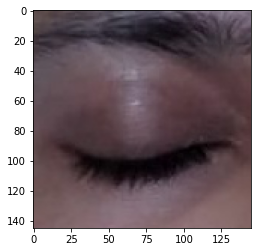

In [6]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("/content/drive/MyDrive/DrowzinessDetection/train/Closed/_0.jpg"))

# image array

In [7]:
a = plt.imread("/content/drive/MyDrive/DrowzinessDetection/train/Closed/_0.jpg")

# image shape

In [8]:
a.shape

(145, 145, 3)

# visualize yawn image. 
# Here background is unnecessary. we need only face image array

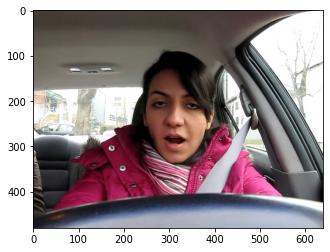

In [9]:
plt.imshow(plt.imread("/content/drive/MyDrive/DrowzinessDetection/train/yawn/10.jpg"))

# for yawn and not_yawn. Take only face

In [11]:
def face_for_yawn(direc="/content/drive/MyDrive/DrowzinessDetection/train", face_cas_path="/content/drive/MyDrive/DrowzinessDetection/haarcascade_frontalface_alt.xml"):
    yaw_no = []
    IMG_SIZE = 24
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        class_num1 += 2
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                resized_array=cv2.cvtColor(resized_array,cv2.COLOR_BGR2GRAY)
                yaw_no.append([resized_array, class_num1])
    return yaw_no


# yawn_no_yawn = face_for_yawn()

# for closed and open eye

In [12]:
def get_data(dir_path="/content/drive/MyDrive/DrowzinessDetection/train/", face_cas="/content/drive/MyDrive/DrowzinessDetection/haarcascade_frontalface_alt.xml", eye_cas="/content/drive/MyDrive/DrowzinessDetection/haarcascade_eye.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 24
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                resized_array=cv2.cvtColor(resized_array,cv2.COLOR_BGR2GRAY)
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [17]:
# data_train = get_data()

# extend data and convert array

In [15]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

# new variable to store

In [16]:
new_data = append_data()

0
1
2
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


# separate label and features

In [18]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

# reshape the array

In [19]:
X = np.array(X)
X = X.reshape(-1, 24, 24, 1)

# LabelBinarizer

In [20]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

# label array

In [21]:
y = np.array(y)

# train test split

In [22]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

# length of X_test

In [24]:
len(X_train)

1064

# Not necessary, only use to matching with my pc version

In [ ]:
# !pip install tensorflow==2.3.1
# !pip install keras==2.4.3

# import some dependencies

In [25]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# tensorflow version

In [26]:
tf.__version__

'2.7.0'

# keras version

In [27]:
import keras
keras.__version__

'2.7.0'

# Data Augmentation

In [28]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [30]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(24,24,1)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))


Epoch 1/50
34/34 [==============================] - 2s 25ms/step - loss: 1.2480 - accuracy: 0.4521 - val_loss: 1.1133 - val_accuracy: 0.6952
Epoch 2/50
34/34 [==============================] - 1s 20ms/step - loss: 1.1281 - accuracy: 0.5197 - val_loss: 0.8656 - val_accuracy: 0.6360
Epoch 3/50
34/34 [==============================] - 1s 19ms/step - loss: 0.8994 - accuracy: 0.6353 - val_loss: 0.5425 - val_accuracy: 0.7829
Epoch 4/50
34/34 [==============================] - 1s 19ms/step - loss: 0.6429 - accuracy: 0.7575 - val_loss: 0.3553 - val_accuracy: 0.8794
Epoch 5/50
34/34 [==============================] - 1s 19ms/step - loss: 0.4841 - accuracy: 0.8308 - val_loss: 0.2879 - val_accuracy: 0.8772
Epoch 6/50
34/34 [==============================] - 1s 19ms/step - loss: 0.4020 - accuracy: 0.8581 - val_loss: 0.2422 - val_accuracy: 0.9057
Epoch 7/50
34/34 [==============================] - 1s 19ms/step - loss: 0.3535 - accuracy: 0.8628 - val_loss: 0.1841 - val_accuracy: 0.9276
Epoch 8/50
34

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 22, 22, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 128)       

# history

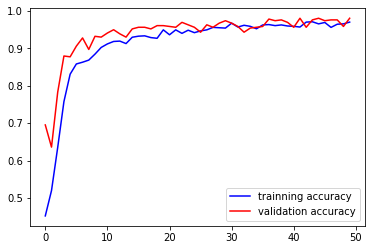

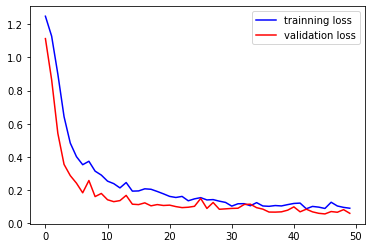

In [32]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

# save model

In [33]:
model.save("drowsiness_new7.h5")